# 01. Tokenization

> ⚡Compute Note: You can run this notebook on CPU. 

Welcome to the first notebook tutorial of the series. This course guides you through the most fundamental concepts required to build Agentic AI applications. All via code, no hand-wavy discussions. And we start from the atomic entity for language models: tokens! 

Tokenization is a task of converting input text into individual tokens that a language model can process. We use the text from [The Verdict](https://en.wikisource.org/wiki/The_Verdict) to train our tokenizers. This notebook introduces the intuition and mechanics behind tokenizing raw text, moving from simple character-based approaches toward more expressive schemes that prepare data for language-model training.

We start with a simple character level tokenization. Here, we consider each character as a token. So, for an input text, each unique character in the text becomes a separate token. 

In [1]:
import plotly.express as px
from collections import defaultdict

In [4]:
class CharTokenizer:
    def __init__(self, training_data: str = "the quick brown fox jumps over the lazy dog"):
        self.training_data = training_data
        self.fit()

    def fit(self):
        self.vocab = sorted(set(self.training_data))
        self.char_to_id = {char: idx for idx, char in enumerate(self.vocab)}
        self.id_to_char = {idx: char for idx, char in enumerate(self.vocab)}
        self.vocab_size = len(self.vocab)

    def plot_token_distribution(self):
        counter = defaultdict(int)
        for token in self.encode(self.training_data):
            counter[token] += 1
        freq = [counter[self.char_to_id[char]] for char in self.vocab]
        fig = px.bar(x=self.vocab, y=freq, labels={'x': 'Token', 'y': 'Frequency'}, width=800, height=300)
        fig.write_html("plot2.html", include_plotlyjs="cdn")
        fig.show()

    def get_compression_ratio(self):
        num_bytes = len(bytes(self.training_data, encoding="utf-8"))
        num_tokens = len(self.encode(self.training_data))
        return num_bytes / num_tokens

    def encode(self, text: str):
        return [self.char_to_id[char] if char in self.char_to_id else '<unk>' for char in text]

    def decode(self, ids: list):
        return ''.join([self.id_to_char[id_] if type(id_) is int else '<unk>' for id_ in ids])

tk = CharTokenizer()
print(tk.vocab_size, tk.vocab)
print(tk.encode("hi, how are you?"))
print(tk.decode(tk.encode("hi, how are you?")))
print('Compression ratio', tk.get_compression_ratio())
tk.plot_token_distribution()

with open("./data/the-verdict.txt", "r") as f:
    data = f.read()
tk = CharTokenizer(data)
print(tk.vocab_size, tk.vocab)
print(tk.encode("hi, how are you?"))
print(tk.decode(tk.encode("hi, how are you?")))
print('Compression ratio', tk.get_compression_ratio())
tk.plot_token_distribution()

27 [' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
[8, 9, '<unk>', 0, 8, 15, 23, 0, 1, 18, 5, 0, 25, 15, 21, '<unk>']
hi<unk> how are you<unk>
Compression ratio 1.0


62 ['\n', ' ', '!', '"', "'", '(', ')', ',', '-', '.', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'L', 'M', 'N', 'O', 'P', 'R', 'S', 'T', 'U', 'V', 'W', 'Y', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
[43, 44, 7, 1, 43, 50, 58, 1, 36, 53, 40, 1, 60, 50, 56, 12]
hi, how are you?
Compression ratio 1.0


Plot for CharTokenizer trained on the string "the quick brown fox jumps over the lazy dog".

<iframe src="https://shreshthtuli.github.io/llms-from-scratch/assets/compression_plot1.html" width="100%" height="350" style="border:none; overflow:hidden;"></iframe>

Plot for CharTokenizer trained on the Verdict.

<iframe src="https://shreshthtuli.github.io/llms-from-scratch/assets/compression_plot2.html" width="100%" height="350" style="border:none; overflow:hidden;"></iframe>

As you can see here vocab sizes are quite small (<100) and the token distribution is quite skewed. This might not be bad for small language models, but if we want to train language models with more and more text, a small vocab size would lead to a very high sequence length which may not be ideal. On the other hand, a very high vocab size can hit curse of dimensionality. 

We thus use a term called compression ratio, which you see above. It is an expected ratio of number of tokens we generate as a sequence for an input text with respect to the byte count of the input. A higher compression ratio shows that our training data would not be as long for us to train with.

Hence, we need a controlled measure for tokenization. One of the ways to do this is use Byte-Pair-Encoding (BPE). Basically, you start with a byte level tokenizer which maps each byte to a new token, hence giving a vocab size of 256. To increase the vocab size in a controlled manner that leads to the highest uplift in the compression ratio, we find the pair of two bytes in the training data that appear the most frequently and allocate a new token for them. We continue this until we get a high enough vocab size and a decent compression ratio. 


References: [Stanford CS336 lecture 1](https://www.youtube.com/watch?v=SQ3fZ1sAqXI&list=PLoROMvodv4rOY23Y0BoGoBGgQ1zmU_MT_), [Andrey Karpathy's video](https://www.youtube.com/watch?v=zduSFxRajkE), [TikTokenizer Visualization](https://tiktokenizer.vercel.app/).

In [5]:
from rich.progress import track
import matplotlib.pyplot as plt


class BPETokenizer(CharTokenizer):
    def __init__(self, training_data: str = "the quick brown fox jumps over the lazy dog", num_merges: int = 10, verbose=False):
        self.num_merges = num_merges
        self.verbose = verbose
        super().__init__(training_data)

    def fit(self):
        self.training_data_bytes = list(self.training_data.encode('utf-8'))
        self.vocab_size = 256
        self.vocab = [chr(i) for i in range(self.vocab_size)]
        self.char_to_id = {char: idx for idx, char in enumerate(self.vocab)}
        self.id_to_char = {idx: char for idx, char in enumerate(self.vocab)}
        self.compression_ratios = [1.0] 

        for _ in track(range(self.num_merges), description="Training BPE..."):
            pair_counts = defaultdict(int)
            
            # count pairs
            for i in range(len(self.training_data_bytes) - 1):
                pair = (self.training_data_bytes[i], self.training_data_bytes[i + 1])
                pair_counts[pair] += 1

            max_pair = max(pair_counts, key=pair_counts.get)            
            self.vocab.append(''.join([self.id_to_char[max_pair[0]], self.id_to_char[max_pair[1]]]))
            if self.verbose:
                print('Training data so far', [self.id_to_char[b] for b in self.training_data_bytes[:50]])
                print('Top 10 pairs', [(self.id_to_char[c1], self.id_to_char[c2], count) for ((c1, c2), count) in [sorted(pair_counts.items(), key=lambda x: x[1], reverse=True)[:10]][0]])
                print(f'New token "{self.vocab[-1]}"')
            self.vocab_size += 1
            self.char_to_id[self.vocab[-1]] = self.vocab_size - 1
            self.id_to_char[self.vocab_size - 1] = self.vocab[-1]

            # merge pair in training data
            new_data = []
            i = 0
            while i < len(self.training_data_bytes):
                if i < len(self.training_data_bytes) - 1 and (self.training_data_bytes[i], self.training_data_bytes[i + 1]) == max_pair:
                    new_data.append(self.vocab_size - 1)
                    i += 2
                else:
                    new_data.append(self.training_data_bytes[i])
                    i += 1
            self.training_data_bytes = new_data

            # calculate compression ratio
            self.compression_ratios.append(self.get_compression_ratio())

    def plot_compression_ratios(self):
        plt.figure(figsize=(8, 3))
        plt.plot(range(len(self.compression_ratios)), self.compression_ratios, marker='o')
        plt.xlabel("Number of Merges")
        plt.ylabel("Compression Ratio")
        plt.title("Compression Ratio vs Number of Merges")
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.tight_layout()
        plt.show()
        
    def encode(self, text: str):
        tokens = []
        i = 0
        while i < len(text):
            match = None
            for j in range(self.vocab_size - 1, -1, -1):
                token = self.id_to_char[j]
                if text.startswith(token, i):
                    match = token
                    break
            if match:
                tokens.append(self.char_to_id[match])
                i += len(match)
            else:
                tokens.append('<unk>')
                i += 1
        return tokens

    def decode(self, ids: list):
        return ''.join([self.id_to_char[id_] if type(id_) is int else '<unk>' for id_ in ids])

tk = BPETokenizer(num_merges=2, verbose=True)

Output()

Training data so far ['t', 'h', 'e', ' ', 'q', 'u', 'i', 'c', 'k', ' ', 'b', 'r', 'o', 'w', 'n', ' ', 'f', 'o', 
'x', ' ', 'j', 'u', 'm', 'p', 's', ' ', 'o', 'v', 'e', 'r', ' ', 't', 'h', 'e', ' ', 'l', 'a', 'z', 'y', ' ', 'd', 
'o', 'g']

Top 10 pairs [('t', 'h', 2), ('h', 'e', 2), ('e', ' ', 2), (' ', 'q', 1), ('q', 'u', 1), ('u', 'i', 1), ('i', 'c', 
1), ('c', 'k', 1), ('k', ' ', 1), (' ', 'b', 1)]

New token "th"

Training data so far ['th', 'e', ' ', 'q', 'u', 'i', 'c', 'k', ' ', 'b', 'r', 'o', 'w', 'n', ' ', 'f', 'o', 'x', ' 
', 'j', 'u', 'm', 'p', 's', ' ', 'o', 'v', 'e', 'r', ' ', 'th', 'e', ' ', 'l', 'a', 'z', 'y', ' ', 'd', 'o', 'g']

Top 10 pairs [('th', 'e', 2), ('e', ' ', 2), (' ', 'q', 1), ('q', 'u', 1), ('u', 'i', 1), ('i', 'c', 1), ('c', 'k',
1), ('k', ' ', 1), (' ', 'b', 1), ('b', 'r', 1)]

New token "the"

Here you see for the training data "the quick brown fox jumps over the lazy dog", in the first iteration, we find the most common token pair is **th**, hence the training data replaces all subsequent occurences of 't' and 'h' to 'th'. Subsequently, we get **the** as the next token and so on. 

Let's now train it on the Verdict data.

In [6]:
with open("./data/the-verdict.txt", "r") as f:
    data = f.read()
tk = BPETokenizer(data, num_merges=350)
print(tk.vocab_size, tk.vocab)
print(tk.encode("hi, how are you?"))
print(tk.decode(tk.encode("hi, how are you?")))
print('Compression ratio', tk.get_compression_ratio())
print('Added tokens ', tk.vocab[256:])
tk.plot_token_distribution()

Output()

606 ['\x00', '\x01', '\x02', '\x03', '\x04', '\x05', '\x06', '\x07', '\x08', '\t', '\n', '\x0b', '\x0c', '\r', '\x0e', '\x0f', '\x10', '\x11', '\x12', '\x13', '\x14', '\x15', '\x16', '\x17', '\x18', '\x19', '\x1a', '\x1b', '\x1c', '\x1d', '\x1e', '\x1f', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~', '\x7f', '\x80', '\x81', '\x82', '\x83', '\x84', '\x85', '\x86', '\x87', '\x88', '\x89', '\x8a', '\x8b', '\x8c', '\x8d', '\x8e', '\x8f', '\x90', '\x91', '\x92', '\x93', '\x94', '\x95', '\x96', '\x97', '\x98', '\x99', '\x9a', '\x9b', '\x9c', '\x9d', '\x9e', '\x9f', '\xa0

Nice! So the BPE tokenizer create tokens for 'e ', ' t', 'd ', 't ', 'in' and so on, and we see they appear quite frequently too, giving us a compression ratio of **2.23**. 

Another interesting aspect of BPE tokenizer is that as we increase the number of merges, we get diminishing returns for the compression ratio. This is because the most frequent character pairs are merged first, leaving progressively less common and impactful pairs for later merges. The initial merges offer a high "compression gain," significantly reducing the total token count and efficiently creating common subwords. However, as the vocabulary grows, the impact of each additional merge on the overall tokenization quality and compression diminishes. 

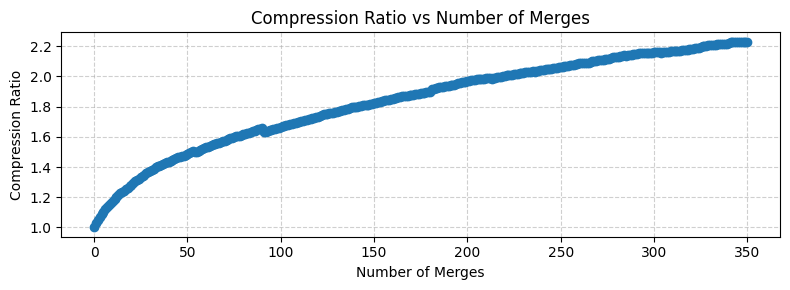

In [7]:
tk.plot_compression_ratios()

Even if we use some of the most advanced tokenizers, such as the __r50k_base__, we get a compression ratio of around 3.98.

We can use different tokenizers. 
- o200k_base: Encoding for the newest GPT-4o-Mini model.
- cl100k_base: Encoding model for newer OpenAI models such as GPT-4 and GPT-3.5-Turbo.
- p50k_base: Encoding for Codex models, these models are used for code applications.
- r50k_base: Older encoding for different versions of GPT-3.

Reference: [tiktoken](https://github.com/openai/tiktoken).

In [28]:
import tiktoken

enc = tiktoken.get_encoding('r50k_base')

print("Vocab size", enc.n_vocab)
print("Compression ratio", len(bytes(data, encoding="utf-8")) / len(enc.encode(data)))

Vocab size 50257
Compression ratio 3.980369290573372


This also has nice special tokens that we will use later, such as `<|endoftext|>` token, which is the last token with token if 50256 for the __r50k_base__ encoder.

In [39]:
encoding = enc.encode("the quick brown fox <|endoftext|> jumps over the lazy dog", allowed_special={'<|endoftext|>'})
print(encoding)
print([enc.decode([token]) for token in encoding])

[1169, 2068, 7586, 21831, 220, 50256, 18045, 625, 262, 16931, 3290]
['the', ' quick', ' brown', ' fox', ' ', '<|endoftext|>', ' jumps', ' over', ' the', ' lazy', ' dog']


As you see here, the r50k tokenizer has a separate token for each word here in the sentence. This is what you can do when you have an enormous vocab size. 

This ends the tokenization tutorial. We will be using the tiktoken library from here on as it is has tokenizers trained by OpenAI on very large corpus of texts from various sources (and not just the Verdict :p) and has several optimizations baked in for quick inference. 